In [1]:
#Importamos las librerias que usaremos en este practica

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer #importar librerias de imputacion
from sklearn.preprocessing import OneHotEncoder,StandardScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline #libreria para pipelines
from sklearn.pipeline import make_pipeline 
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold

import sklearn.metrics as skm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #LDA
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score, f1_score

from time import time
from datetime import timedelta

#importar libreria para leer yaml
import os
import re
import yaml

###
import pickle #Libreria para guardar modelos

#Manejo de Warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
sns.set_style('whitegrid')


###propias
from TukeysOutlierReplacer import TukeysOutlierReplacer

In [2]:
root = re.findall('.*Taller_Practico', os.getcwd())[0]
os.chdir(root)

In [3]:
# Ruta al archivo YAML relativa al directorio encontrado
yaml_file_path = os.path.join(root, 'config.yaml')
#print(yaml_file_path)

### Lectura de datos preparados

In [4]:
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

parquet_path = config['data_path']['stage_processed'] + '/cancer_processed.parquet'
df_parquet = pd.read_parquet(parquet_path)


### definicion de cual será el que se usará
df = df_parquet
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3955 entries, 2987 to 898
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   GENERO                      3955 non-null   object        
 1   ESTADO_CIVIL                3955 non-null   object        
 2   FECHA_NACIMIENTO            3955 non-null   datetime64[ns]
 3   CODIGO_SEDE                 3955 non-null   object        
 4   MULTI_CANCER                3955 non-null   float64       
 5   CESION                      3955 non-null   object        
 6   RIESGOS                     3955 non-null   float64       
 7   CANCER_MAMA_FAMILIAR        3955 non-null   object        
 8   CANCER_OTRO_SITIO           3955 non-null   object        
 9   CANCER_OTRO_SITIO_FAMILIAR  3955 non-null   object        
 10  CEREBRAL_FAMILIAR           3955 non-null   object        
 11  FECHA_DATOS_PESO_TALLA      3955 non-null   datetime64

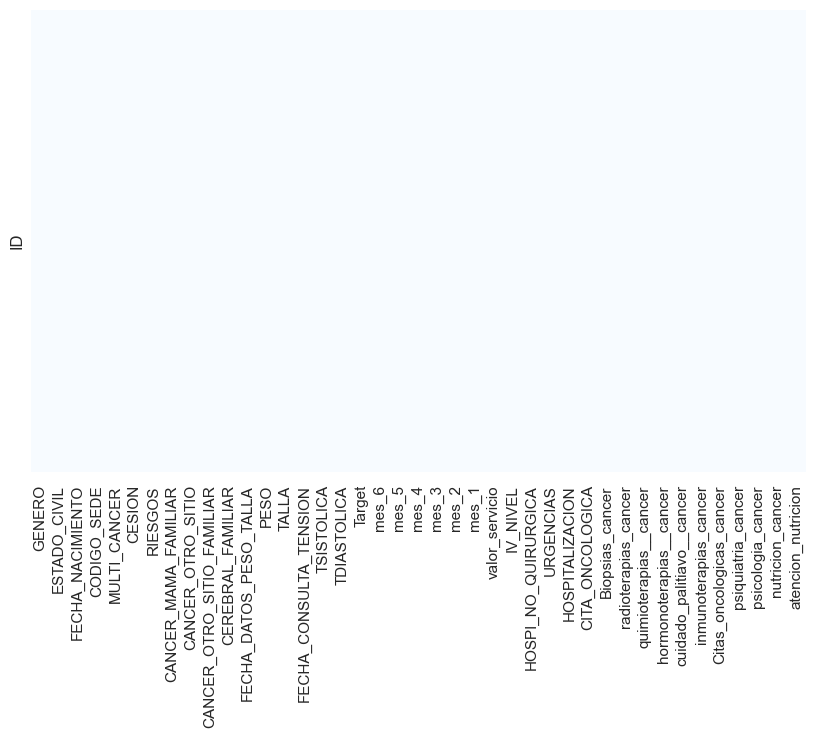

In [5]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

In [6]:
def add_model(data_pipeline, model) -> Pipeline:
    whole_pipeline = Pipeline([
        ("data_pipeline", data_pipeline),
        ("model", model)
    ])
    return whole_pipeline


### Definicion de variable Target

In [7]:
X, y = df.drop(columns="Target"), df["Target"]

### Protocolo de evaluacion [holdout]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Definicion de tipos de variables

In [9]:
categoricas = X_train.select_dtypes('object').columns
categoricas = categoricas.delete(
    categoricas.isin(['CODIGO_SEDE','atencion_nutricion'])
)

numericas = X_train.select_dtypes('number').columns

### Definicion de transformers (ClassTransformer)

In [10]:
class LDATransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        self.clf = LinearDiscriminantAnalysis()
        self.clf.fit(X,y) 
        return self

    def transform(self, X, y=None):
      # Perform arbitary transformation
        X_transformed = X.copy()
        lda = pd.DataFrame(self.clf.transform(X_transformed)).rename(columns={0:'LDA'})
        X_transformed=pd.DataFrame(X_transformed)
        X_transformed = pd.concat([X_transformed,lda],axis=1)
        return X_transformed

### Definicion de transformers (columnTransformer)

In [11]:
numeric_transformer = Pipeline(
    steps=[
            ("imputer", SimpleImputer(strategy="mean")), 
            ("scaler", StandardScaler()),
            ("LDA_feature",LDATransformer()),
            
    ]
)

categorical_transformer = Pipeline(
        steps=[
            ('oneHotEncoder', OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
            ("scaler", StandardScaler())
        ]
    )
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numericas),
        ("cat", categorical_transformer, categoricas),
    ]
)

### Optimizacion Bayesiana
En este paso se reafirmaran los transformers a usar, y se pasaran los mejores hiperparametros para SVC, en este caso se considerarán C, gamma, Kernel.

In [12]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import collections
%matplotlib inline

def live_plot(data_dict, figsize=(7,5), title='', win_size: int = 100):
    """
    Función para mostrar en tiempo real el progreso de la optmización bayesiana.
    """
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        if len(data) > win_size:
            data = data[-win_size:]
            iterations = np.arange(len(data))[-win_size:] 
        else:
            iterations = np.arange(len(data))
        plt.plot(iterations, data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

In [13]:
data = collections.defaultdict(list)

def train_and_evaluate(
    # Data 
    scaler_choice,
    imputer_strategy,
    knn_imputer,
    knn_imputer_k,

    #Modelo SVC
    SVC_C,
    SVC_gamma,
    kernel_SVC

) -> float:
    scaler_cls = StandardScaler if scaler_choice > 0.5 else MinMaxScaler
    imputer_strategy = "mean" if imputer_strategy > 0.5 else "median"
    if knn_imputer > 0.5:
        imputer = KNNImputer(n_neighbors=int(knn_imputer_k))
    else:
        imputer = SimpleImputer(strategy=imputer_strategy)
    kernel = 'linear' if kernel_SVC < 0.33 else ('rbf' if kernel_SVC < 0.67 else 'sigmoid')

    numeric_transformer = Pipeline(
        steps=[("imputer", imputer), 
               ("scaler", scaler_cls()),
               ("LDA_feature",LDATransformer()) 
              ]
    )
    
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numericas),
            ("cat", categorical_transformer, categoricas),
        ]
    )
    
    data_pipeline = Pipeline(steps=[
        ("data_processor", preprocessor),
    ])
           
    #Model SVM
    model = SVC(C=SVC_C, gamma=SVC_gamma, kernel=kernel, probability=True)
    pipeline = add_model(data_pipeline, model)
    show_live_plot=True

    ## Training protocol
    
    kf = KFold(n_splits=3, random_state=963, shuffle=True)
    
    train_fold_metrics = [] 
    val_fold_metrics = []

    # K-Fold cross val
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        #print(f"Fold number: {i+1}")
        kX_train, kX_val = X_train.iloc[train_index], X_train.iloc[test_index]
        ky_train, ky_val = y_train.iloc[train_index], y_train.iloc[test_index]
        #print(f"Training with {kX_train.shape}")
        #print(f"Validating with {kX_val.shape}")
        pipeline.fit(kX_train, ky_train)
        
        val_preds = pipeline.predict_proba(kX_val)[:, 1]
               
        train_preds = pipeline.predict_proba(kX_train)[:, 1]
        
        ths = np.linspace(0, 1, 1000)
        best_th = ths[np.argmax([f1_score(ky_val, val_preds>th) for th in ths])]
        best_th
        
        val_f1 = f1_score(ky_val, val_preds>best_th)
        train_f1 = f1_score(ky_train, train_preds>best_th)
        
        train_fold_metrics.append(train_f1)
        val_fold_metrics.append(val_f1)            
       
    f1_train = np.array(train_fold_metrics)
    f1_val = np.array(val_fold_metrics)
    
    adj_val_f1 = ( f1_val.mean() -  f1_val.std())
    adj_train_f1 = ( f1_train.mean() -  f1_train.std())
    objective = adj_val_f1 - abs(adj_val_f1 - adj_train_f1)
    
    #print(f"Validation F1 adjusted score: {adj_val_f1}")
    #print(f"Train F1 adjusted score: {adj_train_f1}")
    #print()
    
    if show_live_plot:
        data['train_f1'].append(adj_train_f1)
        data['val_f1'].append(adj_val_f1)
        data["objective"].append(objective)
        live_plot(data)
    
    return pipeline, objective

def target_func(**kwargs):
    model, result = train_and_evaluate(**kwargs)
    return result


In [14]:
pbounds = dict(
    # Data
    scaler_choice=(0, 1),
    imputer_strategy=(0, 1),
    knn_imputer=(0,1),
    knn_imputer_k=(3, 10),
    SVC_C=(0.001, 10),
    SVC_gamma=(0,5),
    kernel_SVC=(0,1)
   
)

optimizer = BayesianOptimization(
    f=target_func,
    pbounds=pbounds,
    random_state=963,
    verbose=2,
)


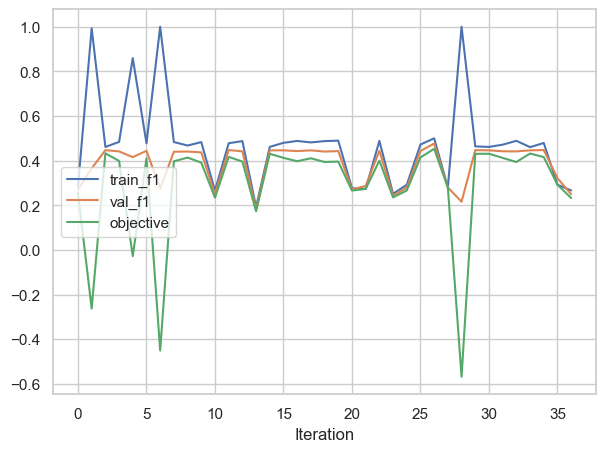

In [15]:
logger = JSONLogger(path="./logs.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

optimizer.maximize(
    n_iter=32,
)

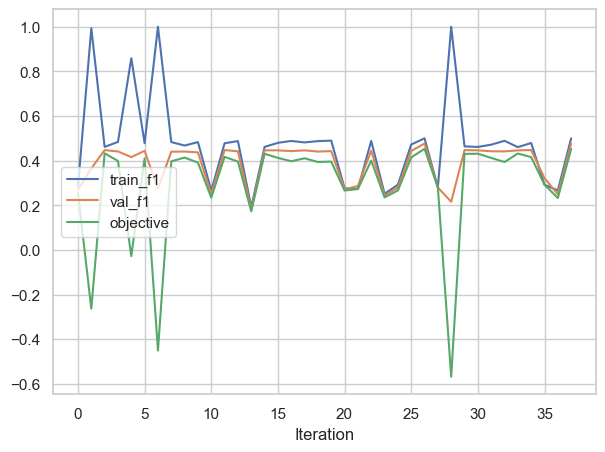

In [16]:
best_model, best_result = train_and_evaluate(**optimizer.max["params"])

In [17]:
best_model.fit(X, y)

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    MinMaxScaler()),
                                                                                   ('LDA_feature',
                                                                                    LDATransformer())]),
                                                                   Index(['MULTI_CANCER', 'RIESGOS', 'PESO', 'TALLA', 'TSISTOLICA', 'TDIASTOLICA',
       'mes_6', 'mes_5', 'mes_4', 'mes_3', 'mes_2', 'mes_1', 'valor_servicio',...
       'Citas_oncologicas_cancer', 'psiquiatria_cancer', 'psicologia_cancer',
       'nutricion_cancer'],
      dtype='object')),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   Index(['GENERO', 'ESTADO_CIVIL', 'CESION', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR'],
      dtype='object'))]))])),
                ('model',
                 SVC(C=0.001, gamma=5.0, kernel='linear', probability=True))])

In [18]:
with open("best_model_svc_opt.pkl", "wb") as f:
    pickle.dump(best_model, f)
test_preds = best_model.predict_proba(X_test)[:, 1]
train_preds = best_model.predict_proba(X_train)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
print(best_th)
test_f1 = f1_score(y_test, test_preds>best_th)
train_f1 = f1_score(y_train, train_preds>best_th)
print(f"Train f1: {train_f1}")
print(f"Test f1: {test_f1}")



0.26226226226226224
Train f1: 0.49484536082474223
Test f1: 0.5909090909090909


In [19]:
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

parquet_path = config['data_path']['github_parquet_test']
test_df = pd.read_parquet(parquet_path)
submission_pred = best_model.predict_proba(test_df)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred_int))
submission.to_csv("submission_modelsvc_opt.csv", index=False)